<div style="border:solid Green 2px; padding: 40px">
    <b> Привет, Светлана!</b>🌸<br/>
    <p>Меня зовут София, я буду ревьюером твоего проекта. Предлагаю обращаться на "ты", но если это неудобно - дай знать, и мы перейдем на "вы".</p>
    <p>Для удобства мои комментарии в твоей работе раскрашены разными цветами:</p>
    <br/>
<div class="alert alert-success">
    <b> ✅**Комментарий ревьюера** </b>
        <p>Такой комментарий означает что решение на отдельном шаге является полностью правильным и я хочу тебя похвалить за отлично выполненную работу. На решения, отмеченные этим комментарием, можно опираться в будущих проектах. </p>
</div>
    <br/>
<div class="alert alert-warning">
    <b>💡**Комментарий ревьюера** </b>
    <p> Такой комментарий я оставляю в случае, когда решение на отдельном шаге станет еще лучше, если внести небольшие коррективы. Ты можешь учесть эти комментарии при выполнении будущих заданий или доработать проект сейчас (однако это не обязательно). </p>
</div>
    <br/>
<div class="alert alert-block alert-danger">
    <b> ❌**Комментарий ревьюера** </b> 
    <p> Такой комментарий оставлен в случае, когда решение на отдельном шаге требует существенной переработки и внесения правок. Проект не может быть принят пока есть, то что которые нужно доработать. </p>
</div>
      <p> Чтобы мы могли вместе эффективнее учиться и развиваться — оставляй свои комментарии и задавай вопросы. Для таких случаев, пожалуйста, выбери собственное оформление комментариев, которое будет отличаться от моего, чтобы не создавать путаницы:</p>
    <div class="alert alert-info"> <b>Комментарий студента:</b> Например, такое.</div>
    <p>По этой же причине попрошу тебя не удалять и не изменять мои комментарии. Все это позволит лучше ориентироваться в нашем с тобой диалоге, а повторную проверку (в случае ее необходимости) выполнять оперативнее. </p>
<p>Не спеши расстраиваться, если что-то не удалось с первого раза. Мы обязательно вместе разберемся со всеми трудностями! </p>
</div>

# Предсказание ДТП

**Главной задачей проекта** является создание системы, которая могла бы оценить риск ДТП по выбранному маршруту движения. Под риском понимается вероятность ДТП с любым повреждением транспортного средства. Как только водитель забронировал автомобиль, сел за руль и выбрал маршрут, система должна оценить уровень риска. Если уровень риска высок, водитель увидит предупреждение и рекомендации по маршруту.

**Идея решения задачи от заказчика**: 
1. Создать модель предсказания ДТП (целевое значение — at_fault (виновник) в таблице parties)
    - Для модели выбрать тип виновника — только машина (car).
    - Выбрать случаи, когда ДТП привело к любым повреждениям транспортного средства, кроме типа SCRATCH (царапина).
    - Для моделирования ограничиться данными за 2012 год — они самые свежие.
    - Обязательное условие — учесть фактор возраста автомобиля.
2. На основе модели исследовать основные факторы ДТП.
3. Понять, помогут ли результаты моделирования и анализ важности факторов ответить на вопросы:
    - Возможно ли создать адекватную системы оценки водительского риска при выдаче авто?
    - Какие ещё факторы нужно учесть?
    - Нужно ли оборудовать автомобиль какими-либо датчиками или камерой?
    
Данные для анализа представлены в базе данных по происшествиям. **ER диаграмма**:

<div class="alert alert-success">
    <b> ✅**Комментарий ревьюера** </b>
        <p>Отлично, что вставляешь задачу проекта и его содержание. Я бы порекомендовала тебе составлять план, больше похожий на книжное содержание.
Например:

# Определение **** <i>(название)</i>
_____
**В исследовании было задействовано несколько таблиц:** **** <i>(описание данных)</i>
______

**Разделим исследование на несколько частей.**

**Часть 1. Изучение общей информации:**
* [1. Изучение файлов с данными, получение общей информации, загрузка библиотек.](#1-bullet)
* [2. Нахождение и ликвидация пропусков.](#2-bullet)

**Часть 2. Подготовка данных:**
* [1. Приведение данных к нужным типам.](#3-bullet)
* [2. Нахождение и исправление аномалий и ошибок.](#4-bullet)
и т.д. </p>
    
<p>Старайся выполнять свой проект в порядке, прописанном в твоем плане. Да, такое оформление займет больше времени, но позволит сделать проект легче в прочтении, не только для меня как ревьюера, но и для тебя, если ты через время решишь вернуться к нему и вспомнить определенные шаги, а также удобнее работодателям, которые будут смотреть портфолио с твоими исследованиями.</p>
<p>Инструкцию по созданию содержания, которое будет удобно построено в виде ссылок на разделы можно найти в курсе: <i> <b> Полезные инструкции для учёбы -> Оформление проекта -> Изменения в Jupyter: автоматическое оглавление и горячие клавиши </b> </i>.</p>
</div>

![schema](данные.png)

<div class="alert alert-warning">
    <b>💡**Комментарий ревьюера** </b>
    <p> Изображение скорее всего расположено локально, поэтому его не видно. </p>
</div>

## Подключитесь к базе. Загрузите таблицы sql

In [1]:
# библиотеки
from sqlalchemy import create_engine

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier

import warnings
warnings.filterwarnings('ignore')

<div class="alert alert-success">
    <b> ✅**Комментарий ревьюера** </b>
        <p>Отлично, что импорты корректно собраны в начале проекта: это соответствует стилевым рекомендациям (PEP 8), а также это удобно в работе (сразу видны используемые библиотеки и что надо доустановить в случае чего). И молодец, что делаешь все импорты из одной библиотеки в одну строку, так легче читать проект и следить за импортами. </p>
</div>

In [2]:
db_config = {
    'user': 'praktikum_student',                           # имя пользователя
    'pwd': 'Sdf4$2;d-d30pp',                               # пароль
    'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
    'port': 6432,                                          # порт подключения
    'db': 'data-science-vehicle-db'                        # название базы данных
}  

connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)

In [3]:
# подключение к БД
engine = create_engine(connection_string) 

## Проведите первичное исследование таблиц

Перед началом работы проверим:

- Соответствует ли количество таблиц условию задачи
- Все ли таблицы имеют набор данных
- Имеется ли общий ключ для связи таблиц

In [4]:
query = """
SELECT table_name
FROM 
    information_schema.tables
WHERE 
    table_schema = 'public';
"""

tables = pd.read_sql_query(query, con=engine)
tables

,table_name
0,case_ids
1,collisions
2,parties
3,vehicles


Количество таблиц в схеме и их названия соответствуют представленным на схеме.

In [5]:
rows = pd.DataFrame(columns=['table_name', 'row_count'])

def row_count(table):
    query = f"""
    SELECT COUNT(*)
    FROM public.{table}
    """
    return pd.read_sql_query(query, con=engine).values[0][0]
    
for table in tables['table_name'].to_list():
    rows.loc[len(rows.index)] = [table, row_count(table)]
    
display(rows)

,table_name,row_count
0,case_ids,1400000
1,collisions,1400000
2,parties,2752408
3,vehicles,1021234


Во всех таблицах есть данные (более 1 млн строк).

In [6]:
def exist_case_id(table):
    query = f"""
    SELECT 
        column_name
    FROM 
        information_schema.columns
    WHERE 
        table_schema = 'public'
        AND table_name = '{table}'
        AND column_name = 'case_id';
    """
    
    if pd.read_sql_query(query, con=engine).shape[0] > 0:
        return f'{table}: Ключ (case_id) есть'
    return 'Общий ключ не найден'

for table in tables['table_name'].to_list():
    print(exist_case_id(table))

case_ids: Ключ (case_id) есть
collisions: Ключ (case_id) есть
parties: Ключ (case_id) есть
vehicles: Ключ (case_id) есть


Судя по представленной ER-диаграмме, общим ключом служит `case_id`. Колонка с таким наименованием присутствует в каждой из таблиц.

Таким образом, **первичное исследование таблиц проведено успешно**: все таблицы содержат данные, количество таблиц и их названия соответствуют ожидаемым и общий ключ содержится в каждой из них. 

<div class="alert alert-success">
    <b> ✅**Комментарий ревьюера** </b>
        <p>Все отлично, проверено наличие таблиц в базе, проверено наличие общего ключа. </p>
</div>

##  Проведите статистический анализ факторов ДТП

Посмотрим, в какие месяцы происходит наибольшее количество аварий:

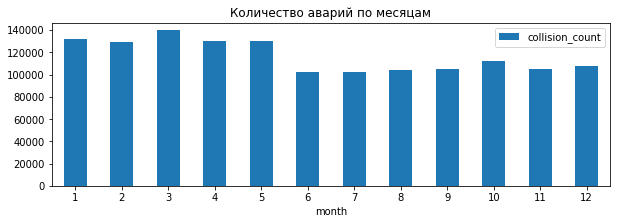

,collision_count
month,
1,132044
2,128858
3,139581
4,130180
5,130316
6,102594
7,102227
8,104089
9,105159


In [7]:
query = '''
SELECT 
    EXTRACT(MONTH FROM collision_date)::integer AS month,
    COUNT(*) AS collision_count
FROM 
    collisions
GROUP BY 
    month
ORDER BY 
    month ASC;
'''

collisions_by_month = pd.read_sql_query(query, con=engine).set_index('month')

# построение графика
collisions_by_month.plot(kind='bar', title='Количество аварий по месяцам', figsize=(10, 3))
plt.xticks(rotation=0)
plt.show()

# данные
display(collisions_by_month.style.background_gradient('Greens'))

<div class="alert alert-warning">
    <b>💡**Комментарий ревьюера** </b>
    <p> Чтобы было легче воспринимать месяцы, можно прочитать их не как числа, а как строки, для этого есть такая функция <code>to_char(<колонка с датами>::DATE, 'MONTH')</code>. </p>
    <p> Так как мы работаем с реальными данными, нам стоит проверить полноту данных за разные месяца по годам. Вдруг, в каком-то году базу заполняли только до половины года, тогда выводы, которые мы будем делать на таких неполных, несбалансированных данных окажутся неверными.

Также можно попробовать сгруппировать данные по сезонам и посмотреть на получившиеся значения, построить график. Это как вариант для более детального анализа.</p>
</div>

Как видно, наибольшее количество аварий зарегистрировано в начале года - в зимние и весенние месяцы. Как раз в это время в некоторых регионах меняются погодные условия, появляется/сходит снег и многие переходят на летнюю резину раньше времени, что приводит к непростой ситуации на дорогах. Меньшее количество аварий наблюдается в летние месяцы. Осенью - наблюдается небольшой рост.

### Задания для коллег:

1. Проанализировать распределение данных о ДТП по годам. Увеличилось ли число зарегистрированных случаев?
2. При каких условиях наблюдаются наиболее серьезные повреждения в ДТП?
3. Исследовать частоту ДТП, произошедших по вине водителя. В каком состоянии находились водители?
4. Исследовать случаи с максимальным количеством участников ДТП
5. Влияет ли возраст автомобиля на размер страховой выплаты в случае серьезного повреждения?
6. Автомобили с каким типом кузова чаще всего попадали в ДТП не по вине водителя с серьезностью повреждения выше среднего?

<div class="alert alert-success">
    <b> ✅**Комментарий ревьюера** </b>
        <p>Отличные задачи для получились! </p>
</div>

Для примера разберем пару вопросов. 

**Вопрос №5** \
"Влияет ли возраст автомобиля на размер страховой выплаты в случае серьезного повреждения?"

*Порядок решения*:
1. Составить sql запрос, связав все три таблицы по общему ключу. В запросе должна присутствовать группировка по возрасту автомобиля, фильтрация по степени серьезности повреждения и вычисление среднего размера страховой выплаты для каждой возрастной группы. Сортировка по увеличинению возраста автомобиля.
2. Построить столбчатую диаграмму и вывести результативную таблицу
3. Сделать вывод

*Пример решения*:

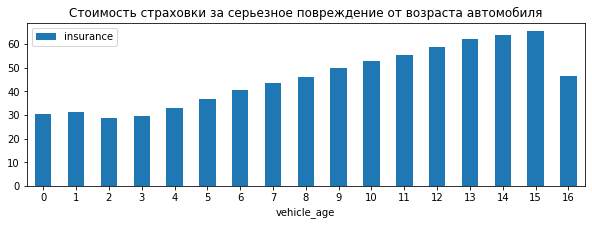

,insurance,case_count
vehicle_age,,
0,30.283896,1929
1,31.285428,2636
2,28.587217,7387
3,29.588541,14586
4,32.814542,11066
5,36.828289,9091
6,40.605540,7603
7,43.479229,7867
8,46.129659,7375


In [8]:
query = """
SELECT v.vehicle_age,
    AVG(p.insurance_premium) AS insurance, 
    COUNT(c.case_id) AS case_count
FROM collisions AS c
JOIN parties AS p ON c.case_id = p.case_id
JOIN vehicles AS v ON v.case_id = p.case_id
WHERE c.collision_damage = 'severe damage'
    AND v.vehicle_age IS NOT NULL
GROUP BY v.vehicle_age
ORDER BY v.vehicle_age
"""

df_pivot = pd.read_sql_query(query, con=engine).set_index('vehicle_age')

# построение графика
df_pivot.plot(kind='bar', y='insurance', title='Стоимость страховки за серьезное повреждение от возраста автомобиля', figsize=(10, 3))
plt.xticks(rotation=0)
plt.show()

# данные
df_pivot.style.background_gradient('Greens')

Общая тенденция: чем старше автомобиль, тем больше средняя страховая выплата за серьезное повреждение. Резкий спад наблюдается для машин возрастом в 16 лет, что связано с крайне малым количеством зарегистрированных случаев.

**Вопрос №6** \
"Автомобили с каким типом кузова чаще всего попадали в ДТП не по вине водителя с серьезностью повреждения выше среднего?"

*Порядок решения*:
1. Составить sql запрос с двумя временными таблицами: количество зарегистированных случаев для каждого типа кузова автомобиля и количество зарегистированных случаев с серьезными или фатальными повреждениями для каждого типа кузова автомобиля. Для решения понадобятся две таблицы - collisions и vehicles. Профильтровать данные по главному фактору дтп "other than driver". Вывести результаты в одной таблице + добавить столбец с процентом серьезных случаев.  
2. Вывести результативную таблицу
3. Сделать вывод

*Пример решения:*

In [9]:
query = """
WITH serious_damage AS (
    SELECT v.vehicle_type, 
        COUNT(c.case_id) AS case_count
    FROM collisions AS c
    JOIN vehicles AS v ON v.case_id = c.case_id
    WHERE c.collision_damage IN ('severe damage', 'fatal tc')
        AND c.primary_collision_factor = 'other than driver'
    GROUP BY v.vehicle_type
),
all_cases AS (
    SELECT v.vehicle_type,
        COUNT(c.case_id) AS case_count
    FROM collisions AS c
    JOIN vehicles AS v ON v.case_id = c.case_id
    WHERE c.collision_damage IS NOT NULL
        AND c.primary_collision_factor = 'other than driver'
    GROUP BY v.vehicle_type
)
    
SELECT a.vehicle_type,
    a.case_count AS all_cases_count,
    s.case_count AS serious_cases_count,
    (s.case_count::numeric / a.case_count::numeric * 100) AS percent
FROM all_cases AS a
JOIN serious_damage AS s ON s.vehicle_type = a.vehicle_type
ORDER BY a.case_count DESC;
"""

df = pd.read_sql_query(query, con=engine)

# данные
df.style.background_gradient('Greens')

,vehicle_type,all_cases_count,serious_cases_count,percent
0,sedan,8868,187,2.108705
1,coupe,5935,459,7.733783
2,minivan,782,122,15.601023
3,hatchback,523,87,16.634799
4,other,51,7,13.725490


Наибольшее количество случаев повреждения не по вине водителя зарегистрировано для автомобилей с типом кузова "sedan", однако, максимальное количество случаев серьезных/фатальных повреждений наблюдается для "coupe". В процентном соотношении же побеждает "hatchback" - 16% от всех представленных случаев не по вине водителя сопровождались крупным ущербом. 

<div class="alert alert-warning">
    <b>💡**Комментарий ревьюера** </b>
    <p> Было бы отлично нарисовать график по этому виду анализа, так как графики воспринимаются в разы легче и кажутся более информативными.
</div>

## Подготовьте данные перед обучением модели

Подготовим набор данных для дальнейшего использования. **Требования:**

1. Целевое значение — at_fault (виновник) в таблице parties
2. Для модели выбрать тип виновника — только машина (car)
3. Выбрать случаи, когда ДТП привело к любым повреждениям транспортного средства, кроме типа SCRATCH (царапина)
4. Для моделирования ограничиться данными за 2012 год — они самые свежие
5. Обязательное условие — учесть фактор возраста автомобиля

Поскольку некоторые колонки в разных таблицах имеют одинаковые названия, перечислим названия всех столбцов и переименуем их при необходимости. Сразу отберем признаки, которые могут быть влиять на риск ДТП.

In [10]:
columns = [
#     'c.case_id',                      # id происшествия - не нужен для модели
#     'c.county_city_location',         # номер района - возьмем только название
    'c.county_location',              # название района - категориальный признак, берем
    'c.distance',                     # расстояние от главной дороги, может влиять
    'c.direction',                    # направление движения, может влиять
#     'c.intersection',                 # перекресток, частично дублируется в c.location_type
    'c.weather_1',                    # погода, может влиять
    'c.location_type',                # тип дороги, может влиять
#     'c.collision_damage',             # серьезность ДТП, неизвестно до аварии
    'c.party_count',                  # число участников - пока непонятно, оставим
#     'c.primary_collision_factor',     # основной фактор аварии, неизвестно до аварии
#     'c.pcf_violation_category',       # категория нарушения, неизвестно до аварии
#     'c.type_of_collision',            # тип аварии, неизвестно до аварии
    'c.motor_vehicle_involved_with',  # доп.участники ДТП, может влиять
    'c.road_surface',                 # состояние дороги, может влиять
    'c.road_condition_1',             # дорожное состояние, может влиять
    'c.lighting',                     # освещенность, может влиять
    'c.control_device',               # устройство управления - пока непонятно, оставим
    'c.collision_date',               # можно будет преобразовать в день недели и месяц
    'c.collision_time',               # можно будет преобразовать в часы или часть дня
#     'v.id',                           # id таблицы vehicle
#     'v.case_id',                      # повтор id происшествия
#     'v.party_number',                 # нет в описании данных к таблице
    'v.vehicle_type',                 # тип кузова, может влиять
    'v.vehicle_transmission',         # тип КПП, может влиять
    'v.vehicle_age',                  # возраст автомобиля, требование заказщика
#     'p.id',                           # id таблицы parties
#     'p.case_id',                      # повтор id происшествия
#     'p.party_number',                 # номер участника, идентификатор
#     'p.party_type',                   # тип участника, по условию только car, не нужен
    'p.at_fault',                     # виновник (0/1) - целевой признак
#     'p.insurance_premium',            # сумма страховки, неизвестно до аварии
    'p.party_sobriety',               # трезвость участника, может влиять
    'p.party_drug_physical',          # состояние участника, может влиять
#     'p.cellphone_in_use'              # наличие телефона - не влияет
]

<div class="alert alert-success">
    <b> ✅**Комментарий ревьюера** </b>
        <p>Здорово, что есть пояснения по выбору признаков для моделирования. </p>
</div>

In [11]:
query = f"""
SELECT {', '.join(columns)}    
FROM collisions AS c
FULL JOIN parties AS p ON c.case_id = p.case_id
FULL JOIN vehicles AS v ON (c.case_id = v.case_id AND p.party_number = v.party_number)
WHERE EXTRACT('year' FROM c.collision_date) = 2012
    AND p.party_type = 'car'
    AND c.collision_damage NOT IN ('scratch')
    AND v.vehicle_age IS NOT NULL
"""

df = pd.read_sql_query(query, con=engine)
display(df.head())
df.info()

,county_location,distance,direction,weather_1,location_type,party_count,motor_vehicle_involved_with,road_surface,road_condition_1,lighting,control_device,collision_date,collision_time,vehicle_type,vehicle_transmission,vehicle_age,at_fault,party_sobriety,party_drug_physical
0,los angeles,20.0,south,clear,None,2,other motor vehicle,dry,normal,daylight,functioning,2012-04-15,17:05:00,sedan,auto,2,0,had not been drinking,None
1,contra costa,21.0,east,clear,None,2,other motor vehicle,dry,normal,dark with street lights,functioning,2012-01-15,02:00:00,sedan,manual,10,0,had not been drinking,None
2,san joaquin,378.0,south,cloudy,None,2,other motor vehicle,dry,normal,daylight,none,2012-04-13,18:32:00,sedan,auto,2,0,had not been drinking,None
3,san bernardino,150.0,west,clear,None,2,other motor vehicle,dry,None,daylight,none,2012-04-29,17:10:00,sedan,auto,3,0,had not been drinking,None
4,los angeles,450.0,east,clear,highway,2,other motor vehicle,dry,normal,daylight,none,2012-04-18,17:15:00,sedan,auto,10,0,had not been drinking,None


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54554 entries, 0 to 54553
Data columns (total 19 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   county_location              54554 non-null  object 
 1   distance                     54554 non-null  float64
 2   direction                    42097 non-null  object 
 3   weather_1                    54389 non-null  object 
 4   location_type                25511 non-null  object 
 5   party_count                  54554 non-null  int64  
 6   motor_vehicle_involved_with  54407 non-null  object 
 7   road_surface                 54225 non-null  object 
 8   road_condition_1             54317 non-null  object 
 9   lighting                     54402 non-null  object 
 10  control_device               54348 non-null  object 
 11  collision_date               54554 non-null  object 
 12  collision_time               54470 non-null  object 
 13  vehicle_type    

<div class="alert alert-warning">
    <b>💡**Комментарий ревьюера** </b>
    <p> В целом, можно было попробовать заполнить пропущенные значения в возрасте, но тут, возможно, будет сложно проследить корреляцию с другими признаками. Поэтому тоже вариант. </p>
</div>

Итого оставили 18 признаков + целевую переменную `at_fault`. Посмотрим на количество пропусков в колонках в процентном соотношении:

In [12]:
pd.DataFrame(df.isna().mean()*100).style.background_gradient('Greens')

,0
county_location,0.000000
distance,0.000000
direction,22.834256
weather_1,0.302453
location_type,53.237160
party_count,0.000000
motor_vehicle_involved_with,0.269458
road_surface,0.603072
road_condition_1,0.434432
lighting,0.278623


В собранном датасете присутствуют три колонки с большим количеством пропусков (более 20%). Восстановить эти данные корректно вряд ли получится, а удалять такое количество строк с пропусками не хочется, поэтому удалим признаки `location_type`, `direction` и `party_drug_physical`. 

In [13]:
df.drop(columns=['direction', 'location_type', 'party_drug_physical'], inplace=True)

Остальные признаки рассмотрим по отдельности.

***County_location***

In [14]:
df['county_location'].value_counts()

los angeles        15715
orange              5079
san diego           3675
san bernardino      3592
riverside           3205
sacramento          2116
alameda             1838
santa clara         1779
ventura             1441
kern                1389
fresno              1057
contra costa         956
san mateo            915
san joaquin          892
stanislaus           786
santa barbara        704
tulare               700
sonoma               677
placer               557
monterey             550
solano               540
san francisco        483
san luis obispo      428
santa cruz           422
merced               383
marin                361
madera               320
humboldt             319
butte                312
el dorado            286
shasta               275
yolo                 266
kings                244
napa                 208
imperial             205
mendocino            189
nevada               181
tehama               145
sutter               143
tuolumne             122


Категориальный признак с названием региона. Все значения уже приведены к нижнему регистру, неявных дубликатов и пропусков нет, однако, в сумме достаточно много уникальных значений. Поскольку объединять их в одну группу будет нецелесообразно, оставим так, как есть.

***Distance***

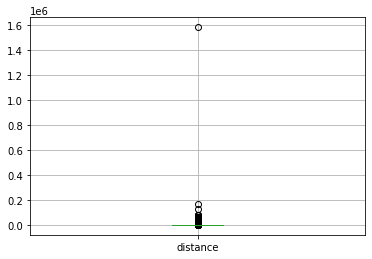

count    5.455400e+04
mean     8.761480e+02
std      7.348699e+03
min      0.000000e+00
25%      9.000000e+00
50%      1.430000e+02
75%      5.757500e+02
max      1.584000e+06
Name: distance, dtype: float64

In [15]:
df.boxplot('distance')
plt.show()

df['distance'].describe()

In [16]:
df['distance'].quantile(0.99)

11616.0

99% всех данных распределены до значения 11616. Ограничим диапазон возможных значений сверху этим значением.

In [17]:
df = df.loc[df['distance'] <= 11616]

***Weather_1***

In [18]:
df['weather_1'].value_counts(dropna=False)

clear      43327
cloudy      8087
raining     2097
fog          168
NaN          165
snowing      144
other         29
wind          11
Name: weather_1, dtype: int64

Категориальный признак. Есть небольшое количество пропусков, заполним их уже существующей заглушкой "other". Также переименуем столбец для удобства.

In [19]:
df['weather_1'] = df['weather_1'].fillna('other')
df.rename(columns={'weather_1': 'weather'}, inplace=True)

***Party_count***

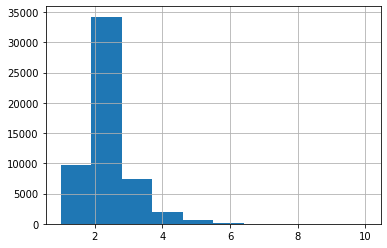

In [20]:
df['party_count'].hist()
plt.show()

Все значения в пределах нормы, пропусков нет.

***Motor_vehicle_involved_with***

In [21]:
df['motor_vehicle_involved_with'].value_counts(dropna=False)

other motor vehicle               39725
fixed object                       7947
non-collision                      2129
other object                       1632
parked motor vehicle               1443
motor vehicle on other roadway      393
bicycle                             375
animal                              222
NaN                                 147
train                                15
Name: motor_vehicle_involved_with, dtype: int64

Есть пропущенные значения. Заполним значением-заглушкой "unknown".

In [22]:
df['motor_vehicle_involved_with'] = df['motor_vehicle_involved_with'].fillna('unknown')

<div class="alert alert-warning">
    <b>💡**Комментарий ревьюера** </b>
    <p>Если интересно, можно попробовать разные методы заполнения пропусков. <a href="https://www.dmitrymakarov.ru/data-analysis/missing-add/">Вот отличная статья об этом c примерами</a>, а <a href="https://robotdreams.cc/blog/103-chto-takoe-propuski-dannyh-i-kak-s-nimi-rabotat">по этой ссылке более кратко</a>.  </p>
</div>

***Road_surface***

In [23]:
df['road_surface'].value_counts(dropna=False)

dry         48290
wet          5052
NaN           325
snowy         321
slippery       40
Name: road_surface, dtype: int64

Аналогично предыдущему случаю.

In [24]:
df['road_surface'] = df['road_surface'].fillna('unknown')

***Road_condition_1***

In [25]:
df['road_condition_1'].value_counts(dropna=False)

normal            51947
construction        979
NaN                 237
obstruction         235
other               213
holes               210
loose material      115
reduced width        62
flooded              30
Name: road_condition_1, dtype: int64

В этом столбце уже есть категория "other". Заполним пропуски ей. Дополнительно изменим название столбца для удобства.

In [26]:
df['road_condition_1'] = df['road_condition_1'].fillna('other')
df.rename(columns={'road_condition_1': 'road_condition'}, inplace=True)

***Lighting***

In [27]:
df['lighting'].value_counts(dropna=False)

daylight                                   36552
dark with street lights                    10592
dark with no street lights                  4902
dusk or dawn                                1700
NaN                                          151
dark with street lights not functioning      131
Name: lighting, dtype: int64

Объединим категории "dark with no street lights" и "dark with street lights not functioning" в одну, т.к. обозначают одно и то же. Пропуски здесь просто удалим.

In [28]:
df['lighting'] = df['lighting'].replace('dark with street lights not functioning', 'dark with no street lights')
df = df.loc[~df['lighting'].isna()]

***Control_device***

In [29]:
df['control_device'].value_counts(dropna=False)

none               36124
functioning        17428
NaN                  186
not functioning      111
obscured              28
Name: control_device, dtype: int64

Заполним пропуски значением-заглушкой "unknown".

In [30]:
df['control_device'] = df['control_device'].fillna('unknown')

***Collision_date***

Преобразуем столбец в два - день недели и месяц. Пропусков в этом столбце нет.

In [31]:
df['collision_date'] = pd.to_datetime(df['collision_date'])
df['month'] = df['collision_date'].dt.month
df['day_of_week'] = df['collision_date'].dt.dayofweek

In [32]:
df[['month', 'day_of_week']].sample(3)

,month,day_of_week
32636,5,1
31567,5,5
44087,4,5


In [33]:
df.drop(columns=['collision_date'], inplace=True)

***Collision_time***

Преобразуем столбец в часы, а часы определим в группы по времени суток. Пропуски удалим.

In [34]:
df['collision_time']

0        17:05:00
1        02:00:00
2        18:32:00
3        17:10:00
4        17:15:00
           ...   
54549    15:55:00
54550    22:45:00
54551    18:20:00
54552    13:25:00
54553    13:45:00
Name: collision_time, Length: 53877, dtype: object

In [35]:
# удаление пропусков
df = df.loc[~df['collision_time'].isna()]

In [36]:
def part_of_day(hour):
    if hour in range(4, 12):
        return 'morning'
    if hour in range(12, 17):
        return 'day'
    if hour in range(17, 24):
        return 'evening'
    return 'night'

df['hour'] = pd.to_datetime(df['collision_time'], format='%H:%M:%S').dt.hour
df['part_day'] = df['hour'].apply(part_of_day)

df.drop(columns=['collision_time', 'hour'], inplace=True)

***Vehicle_type***

In [37]:
df['vehicle_type'].value_counts(dropna=False)

sedan    35128
coupe    18668
other        3
Name: vehicle_type, dtype: int64

Пропусков в столбце нет, неявных дубликатов тоже. 

***Vehicle_transmission***

In [38]:
df['vehicle_transmission'].value_counts(dropna=False)

manual    28126
auto      25103
NaN         570
Name: vehicle_transmission, dtype: int64

Пропуски заполним "unknown".

In [39]:
df['vehicle_transmission'] = df['vehicle_transmission'].fillna('unknown')

***Vehicle_age***

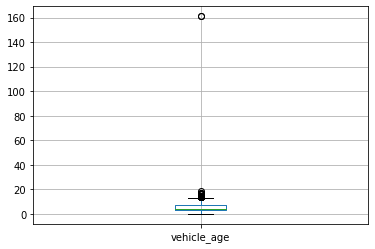

count    53799.000000
mean         4.850443
std          3.237982
min          0.000000
25%          3.000000
50%          4.000000
75%          7.000000
max        161.000000
Name: vehicle_age, dtype: float64

In [40]:
df.boxplot('vehicle_age')
plt.show()

df['vehicle_age'].describe()

Есть выбросы (больше 100 лет автомобилю). Ограничим диапазон значений сверху - 20 лет.

In [41]:
df = df.loc[df['vehicle_age'] <= 20]

***Party_sobriety***

In [42]:
df['party_sobriety'].value_counts(dropna=False)

had not been drinking                     46591
had been drinking, under influence         4298
impairment unknown                         1069
NaN                                         809
had been drinking, not under influence      552
had been drinking, impairment unknown       242
not applicable                              236
Name: party_sobriety, dtype: int64

В столбце есть пропуски. Заполним их категорией "not applicable" (не оценивался).

In [43]:
df['party_sobriety'] = df['party_sobriety'].fillna('not applicable')

Теперь удалим общие дубликаты строк. 

In [44]:
df.drop_duplicates(inplace=True)

**Итого:**

In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53372 entries, 0 to 54553
Data columns (total 17 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   county_location              53372 non-null  object 
 1   distance                     53372 non-null  float64
 2   weather                      53372 non-null  object 
 3   party_count                  53372 non-null  int64  
 4   motor_vehicle_involved_with  53372 non-null  object 
 5   road_surface                 53372 non-null  object 
 6   road_condition               53372 non-null  object 
 7   lighting                     53372 non-null  object 
 8   control_device               53372 non-null  object 
 9   vehicle_type                 53372 non-null  object 
 10  vehicle_transmission         53372 non-null  object 
 11  vehicle_age                  53372 non-null  int64  
 12  at_fault                     53372 non-null  int64  
 13  party_sobriety  

<div class="alert alert-warning">
    <b>💡**Комментарий ревьюера** </b>
    <p> Получилась отличная, подробная предобработка данных. </p>
</div>

**Финальный датасет** включает в себя 15 признаков (3 численных, остальные категориальные) и 1 целевую переменную `at_fault`. Всего 53372 строки. Все пропуски и выбросы устранены.

Разбиение на выборки:

In [46]:
features = df.drop(columns='at_fault')
target = df['at_fault']

features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.25, random_state=123)

Шкалирование числовых признаков и кодирование категориальных в дальнейшем используем в составе пайплайна.

## Создайте модель для оценки водительского риска

Задача предсказания ДТП сводится к задаче классификации. Для оценки качества моделей выберем метрику **f1-score**, т.к. важен баланс между полнотой и точностью предсказания нарушителей. 

Сравним между собой **три ML алгоритма** разных типов для обучения моделей:
1. *Логистическая регрессия*
2. *Случайный лес*
3. *Градиентный бустинг*

Как известно, OHE как кодирование категориальных признаков, хорошо работает для линейных моделей, но для всех остальных, часто, не самый верный выбор. Поэтому будем использовать OHE для линейной регрессии, а OrdinalEncoding для случайного леса и бустинга.

In [47]:
# таблица для результатов
results = pd.DataFrame(columns=['model', 'f1_score', 'mean_fit_time'])

In [48]:
# численные признаки
numeric = ['distance', 'party_count', 'vehicle_age']

# категориальные признаки
categorical = ['county_location', 'weather', 'motor_vehicle_involved_with', 
               'road_surface', 'road_condition', 'lighting', 'control_device', 
               'vehicle_type', 'vehicle_transmission', 'party_sobriety', 
               'month', 'day_of_week', 'part_day']

# предобработчик данных для линейных моделей
preprocessor_linear = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric),
        ('cat', OneHotEncoder(), categorical)])

# предобработчик данных для нелинейных моделей
preprocessor_non_linear = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric),
        ('cat', OrdinalEncoder(), categorical)])

<div class="alert alert-success">
    <b> ✅**Комментарий ревьюера** </b>
    <p> Супер, что используешь пайплайны! </p>
</div>

In [ ]:
%%time
# логистическая регрессия
params = {'lr__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}

pipe = Pipeline(steps=[
    ('preprocessor',  preprocessor_linear),   # предобработка
    ('lr', LogisticRegression(random_state=123, class_weight='balanced', max_iter=1000))])  # классификатор

grid = GridSearchCV(pipe, param_grid=params, scoring='f1', cv=5, n_jobs=4)
grid.fit(features_train, target_train)

print("Лучшие параметры: {}".format(grid.best_params_))
print("Лучший результат (f1): {:.2f}".format(grid.best_score_))
print()

results.loc[len(results.index)] = ['Logistic regression', grid.best_score_, pd.DataFrame(grid.cv_results_).query('rank_test_score == 1')['mean_fit_time'].values[0]]

In [ ]:
%%time
# случайный лес
params = {'rf__n_estimators': [50, 100, 250, 500],
          'rf__max_depth': range(5, 10)}

pipe = Pipeline(steps=[
    ('preprocessor',  preprocessor_non_linear),  # предобработка
    ('rf', RandomForestClassifier())])           # классификатор

grid = GridSearchCV(pipe, param_grid=params, scoring='f1', cv=3, n_jobs=4)
grid.fit(features_train, target_train)

print("Лучшие параметры: {}".format(grid.best_params_))
print("Лучший результат (f1): {:.2f}".format(grid.best_score_))
print()

results.loc[len(results.index)] = ['Random forest', grid.best_score_, pd.DataFrame(grid.cv_results_).query('rank_test_score == 1')['mean_fit_time'].values[0]]

In [ ]:
%%time
# градиентный бустинг
params = {'lgbm__n_estimators': [50, 100, 250, 500],
          'lgbm__max_depth': range(5, 10), 
          'lgbm__learning_rate': [0.5, 1]}

pipe = Pipeline(steps=[
    ('preprocessor',  preprocessor_non_linear),      # предобработка
    ('lgbm', LGBMClassifier())])                     # классификатор

grid = GridSearchCV(pipe, param_grid=params, scoring='f1', cv=3, n_jobs=4)
grid.fit(features_train, target_train)

print("Лучшие параметры: {}".format(grid.best_params_))
print("Лучший результат (f1): {:.2f}".format(grid.best_score_))
print()

results.loc[len(results.index)] = ['LGBM', grid.best_score_, pd.DataFrame(grid.cv_results_).query('rank_test_score == 1')['mean_fit_time'].values[0]]

Результативная таблица:

In [ ]:
results

Лучше всего себя показала модель градиентного бустинга как во времени обучения (примерно 1 сек), так и по качеству: **f1-score** 0.6436. 

**Финальное тестирование модели**

In [ ]:
# обучение модели
pipe = Pipeline(steps=[
    ('preprocessor',  preprocessor_non_linear),
    ('lgbm', LGBMClassifier(learning_rate=0.5, max_depth=5, n_estimators=50))])                     # классификатор

pipe.fit(features_train, target_train)
print()

In [ ]:
# предсказания
preds = pipe.predict(features_test)
f1 = f1_score(target_test, preds)
print('F1-score на тестовой выборке:', round(f1, 4))

# матрица ошибок
cm = confusion_matrix(target_test, preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens')
plt.xlabel('Предсказанные значения')
plt.ylabel('Фактические значения')
plt.title('Матрица ошибок')

# вычисление полноты и точности
precision = precision_score(target_test, preds)
recall = recall_score(target_test, preds)

print('Точность:', round(precision, 4))
print('Полнота:', round(recall, 4))

Таким образом, на тестовой выборке модель градиентного бустинга показала себя примерно так же, как на тренировочной. Точность оказалась выше, чем полнота. Следовательно, модель достаточно точно отделяет один класс от другого (определяет виновника дтп), однако, определяет не всех представителей класса.

## Проведите анализ важности факторов ДТП

In [ ]:
# важность признаков
feature_importance = pipe.named_steps['lgbm'].feature_importances_

# создание DataFrame с важностью признаков
feature_importance_df = pd.DataFrame({'Feature': features_train.columns, 'Importance': feature_importance})

# cортировка по важности признаков
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# построение графика важности признаков
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')
plt.title('Важность признаков')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

Самым важным фактором оказалась локация (признак `county_location`). Далее - погода (`weather`) и количество участников (`party_count`). 

Для примера, влияние погодных условий на распределение классов:

In [ ]:
(pd.crosstab(df['weather'], df['at_fault'], normalize='index')
 .sort_values(by=1, ascending=False)
 .plot(kind='bar'))
 
plt.xticks(rotation=45)
plt.title('Распределение классов в зависимости от погодных условий')
plt.ylabel('class_rate')
plt.show()

Наибольшее количество аварий фиксируется при неблагоприятных погодных условиях: снег, туман и дождь. Когда же погода ясная, распределение классов равномерно. Чтобы учесть этот фактор, можно оборудовать автомобиль электроникой с установленными программами, показывающими прогноз погоды в регионе в течение всего маршрута и заранее предупреждающими о возможных изменениях. 

## Выводы

В рамках данного проекта:
1. Сформирована выгрузка данных из предоставленной БД в соответствии с поставленной задачей. 
2. Был проведен исследовательский анализ данных: некоторые признаки преобразованы, в остальных столбцах были устранены пропуски и выбросы. Перед обучением категориальные признаки были закодированы, а численные - отшкалированы.
3. Были сравнены модели с оптимизированными гиперпараметрами, обученные тремя различными ML алгоритмами: *логистическая регрессия*, *случайный лес* и *градиентный бустинг*. Выбранная метрика оценки качества - *F1-score*.
4. Лучший результат показала **LGBM модель** со следующими значениями гиперпараметров max_depth=5, n_estimators=50, learning_rate=0.5. Полученный F1-score на тренировочной выборке: **0.6436**. F1-score на тестовой: **0.6464**.
5. Дополнительно был проведен анализ важности признаков для модели. Так, наиболее значимыми оказались локация (регион), погода и количество участников.

Таким образом, создание адекватной системы оценки риска при выдаче авто возможно, однако, пока что качество предсказания модели не очень высокое. На улучшение результата, вероятно, сможет повлиять добавление новых признаков, например, водительского стажа. 

<div style="border:solid Green 2px; padding: 40px">

<b>**Общий вывод по проекту**</b>

Спасибо за твой проект! Видно, что в него вложено много сил и проведена большая работа. И проект получился отличным!
    
Кратко пройдусь по впечатлениям. 

<b>Отмечу положительные стороны проекта:</b>
 
* Отличное владение SQL, ты умело используешь сложные конструкции языка!
* Вдумчивая работа с данными, проведен их внимательный анализ, есть промежуточные выводы, пропуски заполнены осмысленно.
* Придуманы отличные задания для анализа данных.
* Хвалю за использование пайплайнов!
* Умелое использование методов предобработки данных.
* Протестированы три модели.
* Есть перебор параметров моделей.

<b>**Возвращаю проект тебе обратно, только чтобы убедиться, что все мои комментарии понятны и в целом по проекту все ясно. Если вдруг у тебя возникнут вопросы, то я с радостью отвечу на них.**</b>

</div>

<div class="alert alert-info"> <b>Комментарий студента:</b> Спасибо большое за ревью проекта! Твои комментарии очень полезные и интересные, я обязательно учту все это в последующих проектах! </div>